In [1]:
from qiskit import *
import numpy as np

In [38]:
def exp_all_z(circuit, quantum_register, 
              pauli_idexes, control_qubit=None, t=1):
    """
    The implementation of exp(iZZ..Z t), where Z is 
    the Pauli Z operator, t is a parameter.
    :param circuit: QuantumCircuit.
    :param quantum_register: QuantumRegister.
    :param pauli_idexes: the indexes from quantum_register that 
                         correspond to entries not equal to I: 
                         e.g. if we have XIYZI then the 
                         pauli_idexes = [0,2,3].
    :param control_qubit: the control Qubit from QuantumRegister 
                          other than quantum_register.
    :param t: the parameter t in exp(iZZ..Z t).
    """
    # the controlled_exp(iIt) special case
    if len(pauli_idexes) == 0 and control_qubit is not None:
        circuit.add_register(control_qubit.register)
        circuit.p(t, control_qubit)
        return
        
    # the first CNOTs
    for i in range(len(pauli_idexes) - 1):
        circuit.cx(quantum_register[pauli_idexes[i]],
                   quantum_register[pauli_idexes[i + 1]])
    
    # Rz gate
    if control_qubit is None:
        circuit.rz(-2 * t, quantum_register[pauli_idexes[-1]])
    else:
        circuit.add_register(control_qubit.register)
        circuit.crz(-2 * t, 
                    control_qubit, quantum_register[pauli_idexes[-1]])
    
    # the second CNOTs
    for i in reversed(range(len(pauli_idexes) - 1)):
        circuit.cx(quantum_register[pauli_idexes[i]],
                   quantum_register[pauli_idexes[i + 1]])

In [39]:
def exp_pauli(pauli, quantum_register, control_qubit=None, t=1):
    """
    The circuit for the exp(i P t), where P is the Pauli term, 
    t is the parameter.
    :param pauli: the string for the Pauli term: e.g. "XIXY".
    :param quantum_register: QuantumRegister.
    :param control_qubit: the control Qubit from QuantumRegister 
                          other than quantum_register.
    :param t: the parameter t in exp(i P t).
    :return: QuantumCircuit that implements exp(i P t) or 
             control version of it.
    """
    if len(pauli) != len(quantum_register):
        raise Exception("Pauli string doesn't match to the quantum register")

    pauli_circuit = QuantumCircuit(quantum_register)
    circuit_bracket = QuantumCircuit(quantum_register)
    pauli_idexes = []

    for i in range(len(quantum_register)):
        if pauli[i] == 'I':
            continue
        elif pauli[i] == 'Z':
            pauli_idexes.append(i)
        elif pauli[i] == 'X':
            circuit_bracket.h(quantum_register[i])
            pauli_idexes.append(i)
        elif pauli[i] == 'Y':
            circuit_bracket.cp(np.pi / 2, np.pi / 2, quantum_register[i])
            pauli_idexes.append(i)

    pauli_circuit = pauli_circuit.compose(circuit_bracket)
    exp_all_z(pauli_circuit, quantum_register, pauli_idexes, control_qubit, t)
    pauli_circuit = pauli_circuit.compose(circuit_bracket)

    return pauli_circuit

In [40]:
def hamiltonian_simulation(hamiltonian, quantum_register=None, 
                           control_qubit=None, t=1, trotter_number=1):
    """
    The implementation of exp(iHt), where H is the Hamiltonian 
    operator, t is the parameter.
    :param hamiltonian: dictionary of Pauli terms with their weights: 
                        e.g. {"XZX": 2, "ZYI": 5, "IYZ": 7}.
    :param quantum_register: QuantumRegister.
    :param control_qubit: the control Qubit from QuantumRegister 
                          other than quantum_register.
    :param t: the parameter t in exp(iHt).
    :param trotter_number: the Trotter number.
    :return: QuantumCircuit that corresponds to exp(iHt) 
             or control version of it.
    """
    if quantum_register is None:
        quantum_register = QuantumRegister(len(list(hamiltonian.keys())[0]))
    if control_qubit in quantum_register:
        raise Exception("the control qubit is in the target register")

    delta_t = t / trotter_number
    exp_hamiltonian = QuantumCircuit(quantum_register)
    exp_delta_t = QuantumCircuit(quantum_register)

    for pauli in hamiltonian:
        weight = hamiltonian[pauli]
        exp_delta_t = exp_delta_t.compose((exp_pauli(pauli, quantum_register, 
                                 control_qubit, weight * delta_t)))

    for i in range(trotter_number):
        exp_hamiltonian = exp_hamiltonian.compose(exp_delta_t)

    return exp_hamiltonian

In [41]:
# put the Hamiltonian in the dictionary
hamiltonian = {"XZX": 2, "ZYI": 5, "IYZ": 7}

quantum_register = QuantumRegister(3, 'q')
circuit = hamiltonian_simulation(hamiltonian, 
                                 quantum_register, t=1/(2*np.pi))

# draw the circuit 
%matplotlib inline
circuit.draw(output="mpl")

CircuitError: "Invalid bit index: '1.5707963267948966' of type '<class 'float'>'"

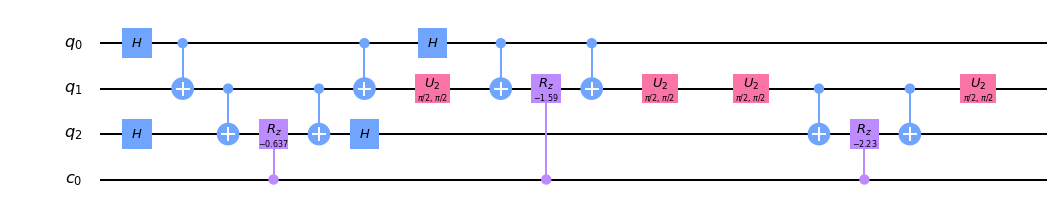

In [6]:
# now the controlled version of the same circuit
control_qubit = QuantumRegister(1, 'c')
control_circuit = hamiltonian_simulation(hamiltonian, quantum_register, 
                                 control_qubit[0], t=1/(2*np.pi))
control_circuit.draw(output="mpl")

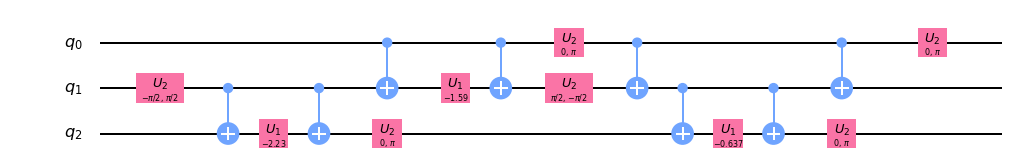

In [7]:
from qiskit.aqua.operators import WeightedPauliOperator
pauli_dict = {
        'paulis': [{"coeff": {"imag": 0.0, "real": 2}, "label": "XZX"},
                   {"coeff": {"imag": 0.0, "real": 5}, "label": "IYZ"},
                   {"coeff": {"imag": 0.0, "real": 7}, "label": "ZYI"}
                   ]
}
hamiltonian = WeightedPauliOperator.from_dict(pauli_dict)

qiskit_evolve_circuit = QuantumCircuit(quantum_register)
qiskit_evolve_circuit = hamiltonian.evolve(
    quantum_registers=quantum_register, evo_time=-1/(2*np.pi))

# construct the circuit with Qiskit basis gates
qiskit_evolve_circuit = transpile(
    qiskit_evolve_circuit, basis_gates=['u1', 'u2', 'u3', 'cx'])

# draw the circuit 
qiskit_evolve_circuit.draw(output="mpl")

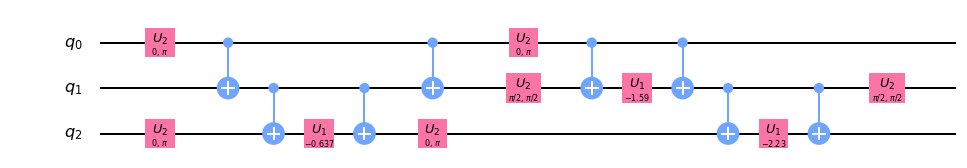

In [8]:
# Let's transpile our previously obtained circuit and draw it
circuit = transpile(circuit, basis_gates=['u1', 'u2', 'u3', 'cx'])
circuit.draw(output="mpl")

Here we will show that these two circuits are equivalent. As one can see our `hamiltonian_simulation` method evolves the Pauli terms in the reversed order than the Qiskit's `evolve` method. The order here is not important, because the Trotter decomposition can be done with different orders of $e^{iPt}$ terms. For this specific chosen Hamiltonian the Pauli terms commute with each other, hence $e^{iPt}$ terms also commute (the order doesn't matter). Another difference between these implementations is that, instead $H_Y = u2(\pi/2, \pi/2)$ Qiskit uses $u2(\pi/2, -\pi/2)$ with its inverse $u2(-\pi/2, \pi/2)$. Note that like $\sigma_y = H_Y \sigma_z H_Y$, the same way:

$$\sigma_y = u2 \left( \pi/2, - \pi/2 \right) \sigma_z u2 \left(-\pi/2, \pi/2 \right)$$

So, these gates are doing the same job as the $H_Y$ gate in our case. The order of the appearance of the $u2(\pi/2, -\pi/2)$ and its inverse $u2(-\pi/2, \pi/2)$ gates in the circuit is important. In contrast, we can forget about this kind of ordering for $H_Y$, because it is a self inverse gate. In this sense, $H_Y$ is a more preferable gate as was pointed out [here][7]. In conclusion, we can say that the circuits that were obtained with the `hamiltonian_simulation` function and Qiskit's `evolve` method are equivalent.

  [1]: https://www.tandfonline.com/doi/abs/10.1080/00268976.2011.552441
  [2]: https://science.sciencemag.org/content/273/5278/1073
  [3]: https://www.cambridge.org/am/academic/subjects/physics/quantum-physics-quantum-information-and-quantum-computation/quantum-computation-and-quantum-information-10th-anniversary-edition?format=HB
  [4]: https://quantumcomputing.stackexchange.com/questions/8725/can-arbitrary-matrices-be-decomposed-using-the-pauli-basis
  [5]: https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/quantum_phase_estimation.ipynb
  [6]: https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/iterative_quantum_phase_estimation.ipynb
  [7]: https://quantumcomputing.stackexchange.com/a/11391/9459

**[[Homepage][8]]**

<h3 align="left">
References
</h3>

[[1]]  [J.D. Whitfield,  J. Biamonte  and  A. Aspuru-Guzik,
Molecular Physics, "Simulation of electronic structure Hamiltonians using
quantum computers" (2011)][1]

[[2]] [Seth Lloyd, Science, "Universal Quantum Simulators" (1996)
][2]

[[3]] [M.A. Nielsen, I.L. Chuang, Cambridge University Press New York, "Quantum Computation and Quantum Information: 10th Anniversary Edition
10th" (2011)][3]

[[4]] [Quantum computing SE question "Can arbitrary matrices be-decomposed using the pauli basis"][4]

  [1]: https://www.tandfonline.com/doi/abs/10.1080/00268976.2011.552441
  [2]: https://science.sciencemag.org/content/273/5278/1073
  [3]: https://www.cambridge.org/am/academic/subjects/physics/quantum-physics-quantum-information-and-quantum-computation/quantum-computation-and-quantum-information-10th-anniversary-edition?format=HB
  [4]: https://quantumcomputing.stackexchange.com/questions/8725/can-arbitrary-matrices-be-decomposed-using-the-pauli-basis
  [5]: https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/quantum_phase_estimation.ipynb
  [6]: https://github.com/DavitKhach/quantum-algorithms-tutorials/blob/master/iterative_quantum_phase_estimation.ipynb
  [7]: https://quantumcomputing.stackexchange.com/a/11391/9459
  [8]: https://github.com/DavitKhach/quantum-algorithms-tutorials
  [9]: https://nbviewer.jupyter.org/github/DavitKhach/quantum-algorithms-tutorials/blob/master/Hamiltonian_simulation.ipynb